In [12]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the directories
images_dir = 'PNG/Original'
masks_dir = 'PNG/Ground Truth'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 400)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in all_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in all_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

if masks.shape[-1] == 3:
    masks = np.mean(masks, axis=-1, keepdims=True)

# Print shapes for debugging
print("Original image shape:", images.shape)
print("Original mask shape:", masks.shape)

masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))


Original image shape: (612, 128, 128, 3)
Original mask shape: (612, 128, 128, 1)


In [4]:
# Split the data into training, validation, and test sets
# 70% training, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

In [5]:
y_train.shape, x_train.shape

((428, 128, 128, 1), (428, 128, 128, 3))

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def create_fcn_model(input_shape=(128, 128, 3), target_shape=(128, 128, 1)):
    model = keras.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder with Skip Connections
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))  # Assuming binary classification

    # Crop to match the target shape
    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model
# Create the FCN model
model = create_fcn_model()

# Display the model summary
model.summary()
model.save('fcn_model.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        

C:\Users\JAGAN\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice




In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [9]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model.compile(optimizer=Adam(lr=.001),loss='binary_crossentropy',
              metrics=[dice_coefficient,"accuracy"])

In [10]:
# Train the model
history = model.fit(x_train, y_train, epochs=15,batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[reduce_lr,checkpoint])
model.save('fcn_model.h5')

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: -190.4119 - dice_coefficient: 1.7041 - accuracy: 0.5628
Epoch 1: val_loss improved from inf to -73.01134, saving model to fcn_model.h5
27/27 [==============================] - 107s 4s/step - loss: -190.4119 - dice_coefficient: 1.7041 - accuracy: 0.5628 - val_loss: -73.0113 - val_dice_coefficient: 1.1856 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: -279.3083 - dice_coefficient: 1.7414 - accuracy: 0.6525
Epoch 2: val_loss did not improve from -73.01134
27/27 [==============================] - 98s 4s/step - loss: -279.3083 - dice_coefficient: 1.7414 - accuracy: 0.6525 - val_loss: 222.0112 - val_dice_coefficient: 0.0290 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: -308.4946 - dice_coefficient: 1.8225 - accuracy: 0.6077
Epoch 3: val_loss did not improve from -73.01134
27/27 [==============================] -

In [13]:
model

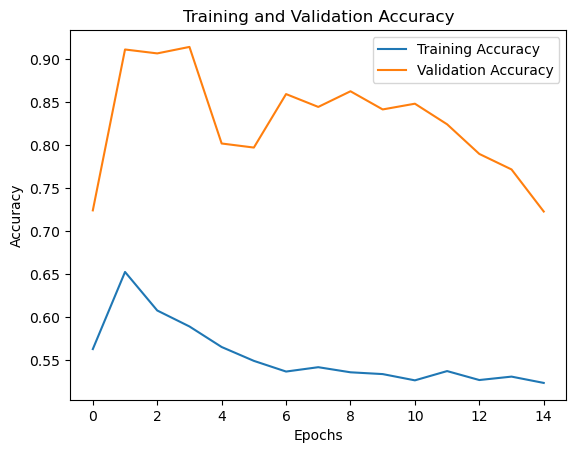

In [14]:
import matplotlib.pyplot as plt

# Get training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
